In [5]:
import pyterrier as pt
import pandas as pd
from LLmsfJiT import read_trec_queries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [7]:
def remap_to_bin(row: pd.core.series.Series):
    if row.label == 2:
        return 1
    else:
        return row.label

In [8]:
topics = pd.DataFrame(list(read_trec_queries("../rel_files/queries.txt").items()), columns=["qid", "query"])
topics["qid"] = topics["qid"].astype(str)

qrels = pd.read_csv("../rel_files/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels["qid"] = qrels["qid"].astype(str)
qrels["label"] = qrels["label"].astype(int)
qrels["label"] = qrels.apply(remap_to_bin, axis=1)

qrels_gpt = pd.read_csv("../gpt_judgements/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels_gpt["qid"] = qrels_gpt["qid"].astype(str)
qrels_gpt["label"] = qrels_gpt["label"].astype(int)
qrels_gpt["label"] = qrels_gpt.apply(remap_to_bin, axis=1)


In [60]:
def generate_experiments_from_index(index_path, topics, qrels):

    index = pt.IndexFactory.of(index_path)
    # tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
    # bm25 = pt.BatchRetrieve(index, wmodel="BM25")
    # DLM = pt.BatchRetrieve(index, wmodel="DirichletLM")
    # pl2 = pt.BatchRetrieve(index, wmodel="PL2")

    retrievers = []
    for wmodel in ["TF_IDF", "BM25", "DirichletLM", "PL2", "CoordinateMatch", "DFIC", "DFIZ", "DFR_BM25", "DFRee", "DFReeKLIM",
                   "Dl", "DLH", "DLH13", "DPH", "Hiemstra_LM", "IFB2", "In_expB2", "In_expC2", "InB2", "InL2", "Js_KLs", "LemurTF_IDF", 
                   "LGD", "Null", "Tf"]:
        retrievers.append(pt.BatchRetrieve(index, wmodel=wmodel))

    experiments = []
    for x in range(topics["qid"].nunique()):
        ex = pt.Experiment(retrievers, topics.iloc[x].to_frame().T, qrels, eval_metrics=["map", "P_5", "P_10",  "ndcg_cut_5", "ndcg_cut_10"])
        experiments.append(ex)
    experiment_df = pd.concat(experiments)
    models = experiment_df["name"].unique()

    index_ls = []
    for q in topics["qid"]:
        index_ls.extend(list(zip(itertools.repeat(q), models) ))

    index = pd.MultiIndex.from_tuples(index_ls, names=["qid", "model"])
    experiment_df.index = index

    experiment_df.drop(columns=["name"], inplace=True)
    return experiment_df

In [61]:
ex_human = generate_experiments_from_index("../pyterrier_indexes/single_field_index/data.properties", topics, qrels)

In [62]:
ex_gpt = generate_experiments_from_index("../pyterrier_indexes/single_field_index/data.properties", topics, qrels_gpt)

In [63]:
human_map = ex_human.groupby("model", as_index=True).map.mean()
gpt_map = ex_gpt.groupby("model", as_index=True).map.mean()

In [64]:
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,     # don't setup fonts from rc parameters
    })

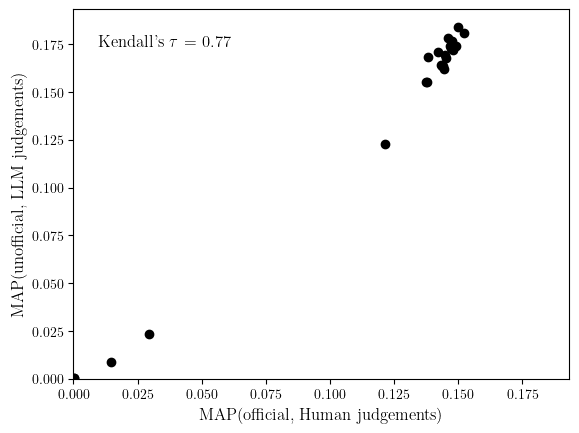

<Figure size 640x480 with 0 Axes>

In [65]:
kt = round(kendalltau(human_map, gpt_map).statistic, 2)
plt.scatter(human_map, gpt_map, color="black")

max_lim = max(plt.xlim()[1], plt.ylim()[1])
plt.text(max_lim/20, max_lim - max_lim/10, f"Kendall's $\\tau$ = {kt}", fontdict={"size": 12})
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.ylabel("MAP(unofficial, LLM judgements)", size=12)
plt.xlabel("MAP(official, Human judgements)", size=12)
plt.show()
plt.savefig("map.pgf", format="pgf")

In [66]:
human_ndcg = ex_human.groupby("model", as_index=True).ndcg_cut_10.mean()
gpt_ndcg = ex_gpt.groupby("model", as_index=True).ndcg_cut_10.mean()

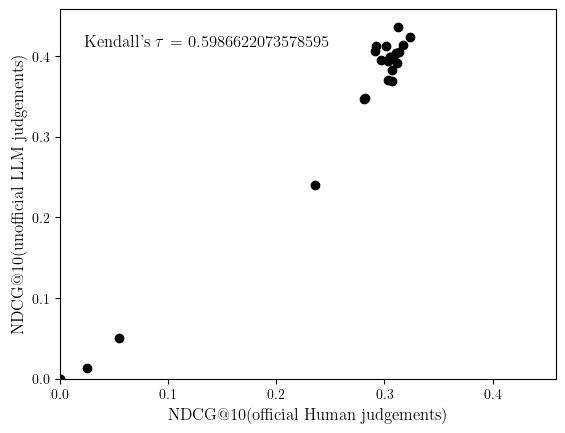

SignificanceResult(statistic=0.5986622073578595, pvalue=2.879182774036441e-05)


In [67]:
kt = kendalltau(human_ndcg, gpt_ndcg)
plt.scatter(human_ndcg, gpt_ndcg, color="black")
max_lim = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.text(max_lim/20, max_lim-max_lim/10, f"Kendall's $\\tau$ = {kt.statistic}", fontdict={"size": 12})
plt.ylabel("NDCG@10(unofficial LLM judgements)", size=12)
plt.xlabel("NDCG@10(official Human judgements)", size=12)
plt.savefig("ndcg.pgf", format="pgf")
plt.show()
print(kt)

## Export data to csv

In [68]:
import csv

In [69]:
ndcg_writer = csv.writer(open("ndcg_data.csv", "w"))

data_ndcg = [("h", "g")]
data_ndcg.extend(list(zip(human_ndcg, gpt_ndcg)))
ndcg_writer.writerows(data_ndcg)

In [70]:
map_writer = csv.writer(open("map_data.csv", "w"))

data_map = [("h", "g")]
data_map.extend(list(zip(human_map, gpt_map)))
map_writer.writerows(data_map)

In [71]:
from scipy.stats import ttest_ind
from itertools import combinations

In [72]:
ex_human_rst = ex_human.reset_index()
ex_gpt_rst = ex_gpt.reset_index()

def compute_sensitivity(df, measurement):
    models = df.model.unique()
    model_pairs = list(combinations(models, 2))

    distinguished_pairs = 0

    for pair in model_pairs:
        row_a = df.loc[np.isin(df.model, pair[0]), measurement]
        row_b = df.loc[np.isin(df.model, pair[1]), measurement]
        if ttest_ind(row_a, row_b).pvalue < 0.05:
            distinguished_pairs += 1

    return round(distinguished_pairs / len(model_pairs), 2)

In [73]:
compute_sensitivity(ex_human_rst, "ndcg_cut_10")

0.29

In [74]:
compute_sensitivity(ex_gpt_rst, "ndcg_cut_10")

0.36

In [75]:
compute_sensitivity(ex_human_rst, "map")

0.29

In [76]:
compute_sensitivity(ex_gpt_rst, "map")

0.34